# Learn the motion from data

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import roslib
import tf
from memmo_utils import *
from database import *
import os
from geometry_msgs.msg import Quaternion, Pose, Point, Vector3
from std_msgs.msg import Header, ColorRGBA
import rospy
import os
from mlp.utils.status import Status
import mlp.utils.wholebody_result as wb_res
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

from transforms3d import axangles
from transforms3d import affines, quaternions

#from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
#from pykdl_utils.kdl_kinematics import KDLKinematics


from regression import *

np.set_printoptions(precision=4, suppress=True)

%load_ext autoreload
%autoreload 2
%matplotlib inline


### Start Instruction

### Load Robot using URDF 

In [ ]:
import roslib; roslib.load_manifest('urdfdom_py')
from urdf_parser_py.urdf import URDF
robot = URDF.from_parameter_server()
clear_output()

tree = kdl_tree_from_urdf_model(robot)

left_foot = KDLKinematics(robot, 'base_link', 'left_sole_link')
right_foot = KDLKinematics(robot, 'base_link', 'right_sole_link')

q = left_foot.random_joint_angles()
pose = left_foot.forward(q) # forward kinematics (returns homogeneous 4x4 numpy.mat)
q_ik = left_foot.inverse(pose, q+0.3) # inverse kinematics

### Create Visualization

In [2]:
viz = Visual()
viz.rate = rospy.Rate(1000)

foot_marker = RvizMarker('foot_marker', 5, Marker.CUBE, 4)
colors = [ColorRGBA(0.0, 1.0, 0.0, 0.7), ColorRGBA(0.0, 0.0, 1.0, 0.7)] + [ColorRGBA(1.0, 0.0, 0.0, 0.9)]*2
foot_marker.set_color(colors)

### Loading Files

In [3]:
FILE_CAT = 'talos_moveEffector_flat'
#FILE_CAT = 'talos_circle'
#FILE_CAT = 'talos_circle_oriented'
ROOT_PROCESSED = '/media/teguh/Data/MEMMO Dataset/processed_data/' + FILE_CAT + '/'
ROOT_CROCS = '/media/teguh/Data/MEMMO Dataset/crocs_data/' + FILE_CAT + '/'

In [4]:
use_crocs = False
if use_crocs:
    f = open(ROOT_CROCS + '/data_left_right.pkl', 'rb')
else:
    f = open(ROOT_PROCESSED + '/data_left_right.pkl', 'rb')
data = pickle.load(f)
f.close()

trajs = dict()
vel_trajs = dict()
x_inputs = dict()
foot_poses = dict()

IOError: [Errno 2] No such file or directory: '/media/teguh/Data/MEMMO Dataset/processed_data/talos_moveEffector_flat//data_left_right.pkl'

shutdown request: new node registered with same name


In [6]:
goal_type = 'contact'#'root'#
num_desired = 600
keys = ['left','right']
num_data = dict()
for key in keys:
    trajs[key] = np.array(data[key]['trajs'])[:num_desired]
    vel_trajs[key] = np.array(data[key]['vel_trajs'])[:num_desired]
    if goal_type == 'contact':
        x_inputs[key] = np.array(data[key]['x_inputs'])[:num_desired]
    elif goal_type == 'root':
        x_inputs[key] = np.array(data[key]['x_inputs_root'])[:num_desired]
    foot_poses[key] = data[key]['foot_poses'][:num_desired]
    num_data[key] = len(foot_poses[key])

#### calculate the control trajectory 

In [7]:
u_trajs = dict()
for key in keys:
    if use_crocs:
        raw_trajs = data[key]['u_trajs']
        for i in range(len(raw_trajs)):
            raw_trajs[i][59] = raw_trajs[i][58]
        u_trajs[key] = np.array(raw_trajs)
    else:
        u_trajs[key] = np.array(data[key]['u_trajs'])[:num_desired]

#### Check for error 

In [8]:
if use_crocs:
    del_indexes = dict()
    for key in keys:
        del_indexes[key] = []
        for i in range(num_data[key]):
            if np.max(np.abs(trajs[key][i])) > 1e2:
                del_indexes[key] += [i]

#### Delete the error data 

In [9]:
if use_crocs:
    for key in keys:
        trajs[key] = np.delete(trajs[key],del_indexes[key],axis=0)
        x_inputs[key] = np.delete(x_inputs[key],del_indexes[key],axis=0)
        foot_poses[key] = np.delete(foot_poses[key],del_indexes[key],axis=0)
        vel_trajs[key] = np.delete(vel_trajs[key],del_indexes[key],axis=0)
        u_trajs[key] = np.delete(u_trajs[key],del_indexes[key],axis=0)    

#### Subsample to the original time intervals (1ms) 

In [10]:
if use_crocs:
    original_T = 3351
    #original_T = 4351

    if use_crocs:
        new_trajs = dict()
        new_vel_trajs = dict()
        new_u_trajs = dict()
        for key in keys:
            new_trajs[key] = []
            new_vel_trajs[key] = []
            new_u_trajs[key] = []
            for i in range(len(trajs[key])):
                traj = trajs[key][i]
                new_traj = subsample(traj, original_T)
                new_trajs[key].append(new_traj)

                vel_traj = vel_trajs[key][i]
                new_vel_traj = subsample(vel_traj, original_T)
                new_vel_trajs[key].append(new_vel_traj)

                u_traj = u_trajs[key][i]
                new_u_traj = subsample(u_traj, original_T)
                new_u_trajs[key].append(new_u_traj)

            new_trajs[key] = np.array(new_trajs[key])
            new_vel_trajs[key] = np.array(new_vel_trajs[key])
            new_u_trajs[key] = np.array(new_u_trajs[key])

        trajs = new_trajs
        vel_trajs = new_vel_trajs
        u_trajs = new_u_trajs

In [11]:
viz.set_rate(1000)

key = 'left'
for i in range(1):
    foot_marker.publish(x_inputs[key][i].reshape(-1,3))
    viz.vis_traj(trajs[key][i])

### Define RBF 

In [7]:
timestep = 3351#trajs['left'].shape[1]
rbf_num = 60
Phi = define_RBF(dof=39, nbStates = rbf_num, offset = 200, width = 60, T = timestep)
%matplotlib qt
plt.plot(Phi)
plt.savefig('/home/rli/git/presentations/MEMMO/2019_sab_meeting/figures/rbf.png')
#clear_output()

[[ 0.0064  0.1253  0.7949 ...,  0.      0.      0.    ]
 [ 0.0061  0.1206  0.7788 ...,  0.      0.      0.    ]
 [ 0.0057  0.116   0.7629 ...,  0.      0.      0.    ]
 ..., 
 [ 0.      0.      0.     ...,  0.7629  0.116   0.0057]
 [ 0.      0.      0.     ...,  0.7788  0.1206  0.0061]
 [ 0.      0.      0.     ...,  0.7949  0.1253  0.0064]]


#### Apply RBF 

In [13]:
def apply_RBF(trajs, Phi, rcond=0.0001):
    w_trajs = []
    for traj in trajs:
        w,_,_,_ = np.linalg.lstsq(Phi, traj, rcond=0.0001)
        w_trajs.append(w.flatten())
    return np.array(w_trajs)
    
def inverse_transform(w_pca, pca, Phi, rbf_num):
    w = pca.inverse_transform(w_pca)
    w = w.reshape(rbf_num,-1)
    traj = np.dot(Phi,w)
    return traj

In [33]:
w_trajs = dict()
w_vel_trajs = dict()
w_u_trajs = dict()

for key in keys:
    w_trajs[key] = apply_RBF(trajs[key], Phi)
    if use_crocs:
        w_vel_trajs[key] = apply_RBF(vel_trajs[key], Phi)
        w_u_trajs[key] = apply_RBF(u_trajs[key], Phi)

### Visualize the approximated trajectories 

#### Try PCA decomposition 

In [26]:
trajs['left'].shape
w_trajs2 = dict()
w_trajs2['left'] = trajs['left'].reshape(600,-1)
w_trajs2['right'] = trajs['right'].reshape(600,-1)

from sklearn.decomposition import PCA
pca = PCA(n_components=40)
import time
tic = time.time()
w_trajs_pca = dict()
w_trajs_pca['left'] = pca.fit_transform(w_trajs2['left'])
w_trajs_pca['right'] = pca.fit_transform(w_trajs2['right'])
toc = time.time()
print toc-tic

7.43407297134


In [36]:
from sklearn.decomposition import PCA

num_pca_comp = 60

w_trajs_pca = dict()
pca = dict()

w_vel_trajs_pca = dict()
pca_vel = dict()

w_u_trajs_pca = dict()
pca_u = dict()

for key in keys:
    pca[key] = PCA(n_components=num_pca_comp)
    w_trajs_pca[key] = pca[key].fit_transform(w_trajs[key])
    
    if use_crocs:
        pca_vel[key] = PCA(n_components=num_pca_comp)
        w_vel_trajs_pca[key] = pca_vel[key].fit_transform(w_vel_trajs[key])

        pca_u[key] = PCA(n_components=num_pca_comp)
        w_u_trajs_pca[key] = pca_u[key].fit_transform(w_u_trajs[key])

In [ ]:
key = 'left'
for i in range(10):
    w_pca = w_trajs_pca[key][i]
    w = pca[key].inverse_transform(w_pca)
    w = w.reshape(60,-1)
    #traj = w.reshape(3351,-1)
    traj = np.dot(Phi,w)
    foot_marker.publish(foot_poses[key][i])
    viz.vis_traj(traj)
    raw_input()

In [29]:
key = 'left'
for i in range(10):
    w_pca = w_trajs_pca[i]
    w = pca.inverse_transform(w_pca)
    traj = w.reshape(3351,-1)
    foot_marker.publish(foot_poses[key][i])
    viz.vis_traj(traj)
    raw_input()

KeyError: 0

### Learning from Data 

In [34]:
from regression import *

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
x_inputs_train = dict()
x_inputs_test = dict()
y_train = dict()
y_test = dict()

y_vel_train = dict()
y_vel_test = dict()

y_u_train = dict()
y_u_test = dict()

for key in keys:
    x_inputs_train[key], x_inputs_test[key], y_train[key], y_test[key] = train_test_split(x_inputs[key],w_trajs_pca[key], test_size = 0.1666, random_state=1)
    if use_crocs:
        _,_, y_vel_train[key], y_vel_test[key] = train_test_split(x_inputs[key],w_vel_trajs_pca[key], test_size = 0.1666, random_state=1)
        _,_, y_u_train[key], y_u_test[key] = train_test_split(x_inputs[key],w_u_trajs_pca[key], test_size = 0.1666, random_state=1)

In [39]:
gpr = dict()
nn = dict()
gmr = dict()

gpr_vel = dict()
gpr_u = dict()

nn_vel = dict()
nn_u = dict()


for key in keys:
    gpr[key] = GPy_Regressor(dim_input=x_inputs_train[key].shape[1],is_transform=True)
    gpr[key].pca = pca[key]
    gpr[key].fit(x_inputs_train[key], y_train[key],num_restarts=3)
    nn[key] = NN_Regressor(K = 1)
    nn[key].fit(x_inputs_train[key], y_train[key])
    nn[key].pca = pca[key]
    #gmr[key] = BGMR_Regressor(n_components=10,n_init = 10)
    #gmr[key].fit(x_inputs_train[key], y_train[key],init_type='random')
    #gmr[key].pca = pca[key]

    if use_crocs:
        gpr_vel[key] = GPy_Regressor(dim_input=x_inputs_train[key].shape[1],is_transform=True)
        gpr_vel[key].pca = pca_vel[key]
        gpr_vel[key].fit(x_inputs_train[key], y_vel_train[key],num_restarts=3)

        nn_vel[key] = NN_Regressor(K = 1)
        nn_vel[key].pca = pca_vel[key]
        nn_vel[key].fit(x_inputs_train[key], y_vel_train[key])

        gpr_u[key] = GPy_Regressor(dim_input=x_inputs_train[key].shape[1],is_transform=True)
        gpr_u[key].pca = pca_u[key]
        gpr_u[key].fit(x_inputs_train[key], y_u_train[key],num_restarts=3)

        nn_u[key] = NN_Regressor(K = 1)
        nn_u[key].pca = pca_u[key]
        nn_u[key].fit(x_inputs_train[key], y_u_train[key])

clear_output()
    

In [37]:
nn = dict()

for key in keys:
    nn[key] = NN_Regressor(K = 1)
    nn[key].fit(x_inputs_train[key], y_train[key])
    nn[key].pca = pca[key]

clear_output()
    

In [40]:
functions = dict()
functions['gpr'] = gpr
functions['nn'] = nn
functions['gmr'] = gmr

if use_crocs:
    functions['gpr_vel'] = gpr_vel
    functions['gpr_u'] = gpr_u
    f = open(ROOT_CROCS + '/functions.pkl', 'wb')
else:
    f = open(ROOT_CROCS + '/functions_A.pkl', 'wb')
pickle.dump(functions, f)
f.close()

#### Load function approximators


In [26]:
FILE_CAT = 'talos_moveEffector_flat'
#FILE_CAT = 'talos_circle'
#FILE_CAT = 'talos_circle_oriented'
ROOT_PROCESSED = '/media/teguh/Data/MEMMO Dataset/processed_data/' + FILE_CAT + '/'
ROOT_CROCS = '/media/teguh/Data/MEMMO Dataset/crocs_data/' + FILE_CAT + '/'
#based on database B
f = open(ROOT_CROCS + '/functions.pkl', 'rb')
functions = pickle.load(f)
f.close()
gpr = functions['gpr']
nn = functions['nn']
gmr = functions['gmr'] 
gpr_vel = functions['gpr_vel']
gpr_u = functions['gpr_u']

In [27]:
#based on database A
f = open(ROOT_CROCS + '/functions_A.pkl', 'rb')
functions_A = pickle.load(f)
f.close()
gpr_A = functions_A['gpr']
nn_A = functions_A['nn']
gmr_A = functions_A['gmr'] 

#### Accuracy Comparison

In [28]:
def calc_diff_pose(pose_true, pose_pred):
    diff = 0.
    for i in range(len(pose_true)):
        diff += np.linalg.norm(pose_true[i] - pose_pred[i])
    return diff

### Test Memory

In [41]:
from sklearn.mixture import GaussianMixture
gmm = dict()
for key in keys:
    gmm[key] = GaussianMixture(n_components=30, n_init = 3) 
    gmm[key].fit(x_inputs[key])

In [42]:
viz.set_rate(1000)

In [62]:
def toggle_key(key):
    if key == 'left':
        return 'right'
    else:
        return 'left'

In [65]:
indexes = [0, 3, 7, 8, 9, 12, 13]

In [92]:
keys = ['left', 'right']

nn_A = dict()
for key in keys:
    x = gpr_A[key].gp.X
    y = gpr_A[key].gp.Y
    nn_A[key] = NN_Regressor()
    nn_A[key].fit(x,y)
    nn_A[key].pca = gpr_A[key].pca

In [ ]:
indexes = [2,4,6,8,11,14,20,21]

In [ ]:
FIG_FILE_NAME = "/home/teguh/git/publications/memmo_icra_2020/videos/gmr_"
key = 'right'
fig_index = 0
for i in (indexes):
#for i in range(50):  
    print i
    if i%2 == 0:
        key = 'left'
    else:
        key = 'right'
    x = x_inputs_test[key][np.random.randint(x_inputs_test[key].shape[0])][None,:]
    #x = x_inputs_test[key][i][None,:]
    
    #x,_ = gmm[key].sample()
    func = gpr

    #w_pca,cov = gmr[key].predict(x.flatten())
    w_pca,cov = func[key].predict(x)
    w_pca = mvn(mean=w_pca.flatten(),cov=0.01*np.eye(w_pca.shape[1])).rvs()
    w_pca[15:] *=0.
    print w_pca
    #print cov
    w = func[key].pca.inverse_transform(w_pca)
    #w = w.reshape(rbf_num,-1)
    #traj = np.dot(Phi,w)
    traj = w.reshape(3351,-1)
    if goal_type == 'contact':
        foot_marker.publish(x.reshape(-1,3))    
    elif goal_type == 'root':
        foot_marker.publish(x[0,0:6].reshape(-1,3))    
        viz.br.sendTransform(traj[0,0:3], normalize(traj[0,3:7]),
         rospy.Time.now(),
         "init",
         "world"
         )
        viz.br.sendTransform(x[0,6:9], normalize(x[0,9:13]),
                 rospy.Time.now(),
                 "goal",
                 "world"
                 )
    
    
    '''
    viz.set_dof(traj[0])
    time.sleep(0.2)
    for j,index in enumerate(np.arange(0,3350,50)):
        viz.set_dof(traj[index])
        time.sleep(0.04)
        #ave_screenshot(200,200,700,700, FIG_FILE_NAME +  str(fig_index) + '.png') 
        fig_index +=1
    for k in range(20):
        #save_screenshot(200,200,700,700, FIG_FILE_NAME  +  str(fig_index)  + '.png') 
        fig_index +=1
    '''
    
    viz.vis_traj(traj)
    #dec = raw_input()
    #if dec == 'y':
    #    indexes += [i]
    #key = toggle_key(key)
    clear_output()

In [77]:
viz.set_dof(traj[0])

In [79]:
for j,index in enumerate(np.arange(0,3350,50)):
    viz.set_dof(traj[index])
    time.sleep(0.04)
    save_screenshot(200,200,700,700, FIG_FILE_NAME + '_' + str(i)+ str(j) + '.png') 

clear_output()


In [128]:
os.system('ffmpeg -r 25 -start_number 0 -i /home/teguh/git/publications/memmo_icra_2020/videos/gpr_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p /home/teguh/git/publications/memmo_icra_2020/videos/gpr.mp4')

os.system('ffmpeg -r 25 -start_number 0 -i /home/teguh/git/publications/memmo_icra_2020/videos/gmr_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p /home/teguh/git/publications/memmo_icra_2020/videos/gmr.mp4')

os.system('ffmpeg -r 25 -start_number 0 -i /home/teguh/git/publications/memmo_icra_2020/videos/nn_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p /home/teguh/git/publications/memmo_icra_2020/videos/nn.mp4')

os.system('ffmpeg -r 25 -start_number 0 -i /home/teguh/git/publications/memmo_icra_2020/videos/gpra_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p /home/teguh/git/publications/memmo_icra_2020/videos/gpr_A.mp4')

os.system('ffmpeg -r 25 -start_number 0 -i /home/teguh/git/publications/memmo_icra_2020/videos/gmra_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p /home/teguh/git/publications/memmo_icra_2020/videos/gmr_A.mp4')

os.system('ffmpeg -r 25 -start_number 0 -i /home/teguh/git/publications/memmo_icra_2020/videos/nna_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p /home/teguh/git/publications/memmo_icra_2020/videos/nn_A.mp4')

#### Getting the distribution of trajectories 

### Warmstart crocoddyl

#### Loading function approximators 

In [28]:
#based on database B
f = open(ROOT_CROCS + '/functions.pkl', 'rb')
functions = pickle.load(f)
f.close()
gpr = functions['gpr']
nn = functions['nn']
gmr = functions['gmr'] 

gpr_vel = functions['gpr_vel']
gpr_u = functions['gpr_u']

#based on database A
f = open(ROOT_CROCS + '/functions_A.pkl', 'rb')
functions_A = pickle.load(f)
f.close()
gpr_A = functions_A['gpr']
nn_A = functions_A['nn']
gmr_A = functions_A['gmr'] 

In [29]:
def calc_foot_T(x, move = 'left'):
    #calculate the footstep transformation matrix based on the input x
    #x is defined as: [left_foot, right_foot, 'foot_to_move']
    x = x.reshape(-1,3)
    Ts = []
    for x_i in x:
        T = PosetoMat(x_i)
        Ts.append(T)
    
    if move == 'left':
        T_lefts = [Ts[0], None, Ts[2]]
        T_rights = [Ts[1]]*3
    else:
        T_rights = [Ts[1], None, Ts[2]]
        T_lefts = [Ts[0]]*3
        
    return T_lefts, T_rights

#### Create a problem

In [30]:
if np.random.rand() < 0.5:
    key = 'left'
else:
    key = 'right'
x,_ = gmm[key].sample()

In [34]:
T_lefts, T_rights = calc_foot_T(x,move=key)
foot_marker.publish(x.reshape(-1,3))

#predict the trajectory
w_pca,cov = gpr[key].predict(x)
w = gpr[key].pca.inverse_transform(w_pca)
w = w.reshape(rbf_num,-1)
traj = np.dot(Phi,w)

#predict the velocity trajectory
w_pca,cov = gpr_vel[key].predict(x)
w = gpr_vel[key].pca.inverse_transform(w_pca)
w = w.reshape(rbf_num,-1)
vel_traj = np.dot(Phi,w)

#predict the control trajectory
w_pca,cov = gpr_u[key].predict(x)
w = gpr_u[key].pca.inverse_transform(w_pca)
w = w.reshape(rbf_num,-1)
u_traj = np.dot(Phi,w)


#visualize
viz.set_rate(1000)
#viz.vis_traj(traj)

#### Create phases

In [35]:
data_phases = []
data_phases.append(np.arange(0,25))
data_phases.append(np.arange(25,60))
data_phases.append(np.arange(60,85))
delta_t = 0.04

In [36]:
data_phases_ori = [data_phases]

#### Subsample the trajectories 

In [37]:
T = traj.shape[0]
intervals = np.concatenate([np.arange(0,T,40),[T-1]])
T_new = len(intervals)
traj = traj[intervals]
#vel_traj = np.zeros((traj.shape[0], 38))
#u_traj = np.zeros((traj.shape[0], 32))

#for visualization
viz.set_rate(25)
raw_traj = traj.copy()

#### Store in Crocoddyl format 

In [38]:
phases = store_for_crocoddyl(traj, vel_traj, u_traj, T_lefts, T_rights, data_phases, delta_t)
pickle.dump(phases,open('data_teguh_3.txt','wb'))

### Run Crocoddyl 

In [39]:
from memmo_utils import *
from crocoddyl import loadTalos
from croc_lib import *

In [40]:
ROBOT = loadTalos('/opt/openrobots/share/example-robot-data')
problem, xs, us, ts = define_croc_problem(ROBOT,'data_teguh_3.txt', num_phases=3, is_warmstart=True)
clear_output()

solver = solve_problem(ROBOT,problem,xs, us,maxiter = 50, STOP_THRESHOLD=1e-03, recalc_u=False, TYPE_OF_SOLVER='FDDP')
traj = np.array(solver.xs)[:,0:39]


*** SOLVE ***
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.29404e+01  4.55276e+01  2.24253e+02  1.00000e-09  1.00000e-09   1.0000     1
   1  5.26902e+01  3.90969e-02  1.77882e+01  1.00000e-09  1.00000e-09   0.1250     1
   2  5.26887e+01  3.46635e-02  1.67801e+01  1.00000e-08  1.00000e-08   0.0020     1
   3  5.26887e+01  3.46636e-02  1.67797e+01  1.00000e-07  1.00000e-07   0.0020     1
   4  5.26887e+01  3.46638e-02  1.67758e+01  1.00000e-06  1.00000e-06   0.0020     1
   5  5.26887e+01  3.46662e-02  1.67372e+01  1.00000e-05  1.00000e-05   0.0020     1
   6  5.26891e+01  3.46798e-02  1.63727e+01  1.00000e-04  1.00000e-04   0.0020     1
   7  5.26913e+01  3.43833e-02  1.39629e+01  1.00000e-03  1.00000e-03   0.0020     1
   8  5.26948e+01  3.39239e-02  7.98409e+00  1.00000e-02  1.00000e-02   0.0020     1
   9  5.26895e+01  5.11997e-02  2.82246e+00  1.00000e-01  1.00000e-01   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas

KeyboardInterrupt: 

In [41]:
ROBOT = loadTalos('/opt/openrobots/share/example-robot-data')
problem, xs, us, ts = define_croc_problem(ROBOT,'data_teguh_3.txt', num_phases=3, is_warmstart=False)
clear_output()

solver = solve_problem(ROBOT,problem,xs, us,maxiter = 50, STOP_THRESHOLD=1e-02, recalc_u=True, TYPE_OF_SOLVER='FDDP')
traj2 = np.array(solver.xs)[:,0:39]


*** SOLVE ***
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  1.31792e+03  9.47168e+03  1.04977e+05  1.00000e-09  1.00000e-09   1.0000     1
   1  2.69850e+02  1.62488e+02  2.29574e+03  1.00000e-09  1.00000e-09   1.0000     1
   2  1.48365e+02  4.65790e+00  3.40610e+02  1.00000e-09  1.00000e-09   1.0000     1
   3  1.05430e+02  7.98838e-01  1.18140e+02  1.00000e-09  1.00000e-09   1.0000     1
   4  9.52031e+01  4.99526e-02  5.03424e+01  1.00000e-09  1.00000e-09   1.0000     1
   5  9.16454e+01  3.25150e-01  3.30420e+01  1.00000e-09  1.00000e-09   1.0000     1
   6  9.00612e+01  1.77993e-01  2.54104e+01  1.00000e-09  1.00000e-09   1.0000     1
   7  9.00601e+01  3.86682e-02  2.03232e+01  1.00000e-08  1.00000e-08   0.0020     1
   8  9.00601e+01  3.86686e-02  2.03223e+01  1.00000e-07  1.00000e-07   0.0020     1
   9  9.00601e+01  3.86732e-02  2.03137e+01  1.00000e-06  1.00000e-06   0.0020     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas

KeyboardInterrupt: 

In [329]:
viz.vis_traj(traj)

In [330]:
viz.vis_traj(traj2)

In [ ]:
#A quick check
#calc_foot_pose(traj[0], left_foot, right_foot)
compare_phases_with_result(phases, np.array(solver.xs), left_foot, right_foot, viz)

### Comparison between Coldstart and Warmstart 

In [31]:
from croc_lib import *
ROBOT = loadTalos('/opt/openrobots/share/example-robot-data')


In [32]:
data_phases_ori = []
data_phases_ori.append(np.arange(0,1001))
data_phases_ori.append(np.arange(1001,2361))
data_phases_ori.append(np.arange(2361, 3351))

In [33]:
viz.set_rate(1000)

In [38]:
key = 'left'
file_name = 'data.txt'

result = dict()
res_keys = ['gpr', 'gmr', 'gpr_A', 'gmr_A','cold', 'q', 'qu', 'q_nou', 'u']
wm_methods = [gpr,gmr,gpr_A, gmr_A]
#wm_methods = []
for res_key in res_keys:
    result[res_key] = dict()
    result[res_key]['trajs'] = []
    result[res_key]['vel_trajs'] = []
    result[res_key]['u_trajs'] = []
    
    result[res_key]['n_iters'] = []
    result[res_key]['costs'] = []
    result[res_key]['x_inputs'] = []

trajs_true = []
    
#for i in range(3):

In [41]:
key = 'right'
tic = time.time()
for i in range(len(x_inputs_test[key])):
    print 'Iteration ' + str(i)
    toc = time.time()
    print 'Time so far: ' + str(toc-tic)
    #create problem
    #x_input,_ = gmm[key].sample()
    x_input = x_inputs_test[key][i:i+1]
    foot_marker.publish(x_input.reshape(-1,3))
    w_pca_true = y_test[key][i]
    w = pca[key].inverse_transform(w_pca_true)
    w = w.reshape(rbf_num,-1)
    traj_true = np.dot(Phi,w)
    trajs_true.append(traj_true)
    
    
    #viz.vis_traj(traj_true)
    q_init = traj_true[0]
    v_init = np.zeros(38)
    
    #warmstart method
    for j, func in enumerate(wm_methods):
        res_key = res_keys[j]
        #predict the trajectory
        w_pca,cov = func[key].predict(x_input)
        w = func[key].pca.inverse_transform(w_pca)
        w = w.reshape(rbf_num,-1)
        traj = np.dot(Phi,w)

        traj_mod,_ = convert_to_croc_format(x_input,traj,key, data_phases = data_phases_ori,\
                                q_init = q_init, v_init = v_init, filename=file_name)
        print 'warmstart step' + res_key
        problem, xs, us, ts = define_croc_problem(ROBOT,file_name, num_phases=3, is_warmstart=True)

        solver = solve_problem(ROBOT,problem,xs, us,maxiter = 20, STOP_THRESHOLD=1e-02, recalc_u=True, TYPE_OF_SOLVER='FDDP')
        traj = np.array(solver.xs)[:,0:39]
        result[res_key]['trajs'] += [traj]
        result[res_key]['n_iters'] += [solver.iter]
        result[res_key]['costs'] += [solver.cost]
        result[res_key]['x_inputs'] += [x_input]
        
    
    print 'coldstart step'
    problem, xs, us, ts = define_croc_problem(ROBOT,file_name, num_phases=3, is_warmstart=False)

    solver = solve_problem(ROBOT,problem,xs, us,maxiter = 20, STOP_THRESHOLD=1e-02, recalc_u=True, TYPE_OF_SOLVER='FDDP')
    traj = np.array(solver.xs)[:,0:39]
    res_key = 'cold'
    result[res_key]['trajs'] += [traj]
    result[res_key]['n_iters'] += [solver.iter]
    result[res_key]['costs'] += [solver.cost]
    

    
    #predict the trajectories
    w_pca,cov = gpr[key].predict(x_input)
    w = gpr[key].pca.inverse_transform(w_pca)
    w = w.reshape(rbf_num,-1)
    traj = np.dot(Phi,w)

    w_pca,cov = gpr_vel[key].predict(x_input)
    w = gpr_vel[key].pca.inverse_transform(w_pca)
    w = w.reshape(rbf_num,-1)
    vel_traj = np.dot(Phi,w)

    w_pca,cov = gpr_u[key].predict(x_input)
    w = gpr_u[key].pca.inverse_transform(w_pca)
    w = w.reshape(rbf_num,-1)
    u_traj = np.dot(Phi,w)

    
    wm_comps = ['q', 'qu', 'q_nou', 'u']
    for res_key in wm_comps:
        if res_key == 'q':
            inputs = [traj.copy(),None,None]
            recalc = True
        elif res_key == 'q_nou':
            inputs = [traj.copy(),None,None]
            recalc = False
        elif res_key == 'qu':
            inputs = [traj.copy(),None,u_traj]
            recalc = False
        elif res_key == 'qv':
            inputs = [traj.copy(),vel_traj,None]
            recalc = True
        elif res_key == 'qvu':
            inputs = [traj.copy(),vel_traj,u_traj]
            recalc = False
        elif res_key == 'u':
            inputs = [traj.copy()*0,None,u_traj]
            recalc = False
            
        
        traj_mod,_ = convert_to_croc_format(x_input,traj=inputs[0], vel_traj = inputs[1], \
                                u_traj = inputs[2], key = key, data_phases = data_phases_ori,\
                                q_init = q_init, v_init = v_init, filename=file_name)
        print 'warmstart step' + res_key
        problem, xs, us, ts = define_croc_problem(ROBOT,file_name, num_phases=3, is_warmstart=True)

        solver = solve_problem(ROBOT,problem,xs, us,maxiter = 20, STOP_THRESHOLD=1e-02, recalc_u=recalc, TYPE_OF_SOLVER='FDDP')
        res_traj = np.array(solver.xs)[:,0:39]
        result[res_key]['trajs'] += [res_traj]
        result[res_key]['vel_trajs'] += [np.array(solver.xs)[:,39:]]
        result[res_key]['u_trajs'] += [np.array(solver.us)]
        result[res_key]['n_iters'] += [solver.iter]
        result[res_key]['costs'] += [solver.cost]
        result[res_key]['x_inputs'] += [x_input]
    
    
    
    
    clear_output()
    success = dict()
    for res_key in res_keys:
        success[res_key] = np.array(result[res_key]['costs']) < 1e2
        print"{0} \t & {1:.2f} & \t {2:.2f} $\\pm${3:.2f} & \t {4:.2f} $\\pm$ {5:.2f}".format(res_key,  100.*np.sum(success[res_key])/(len(success[res_key])+.000001), np.mean(np.array(result[res_key]['costs'])[success[res_key]]), np.std(np.array(result[res_key]['costs'])[success[res_key]]), np.mean(np.array(result[res_key]['n_iters'])[success[res_key]]),np.std(np.array(result[res_key]['n_iters'])[success[res_key]]))

gpr 	 & 100.00 & 	 55.32 $\pm$7.99 & 	 2.04 $\pm$ 0.41
gmr 	 & 100.00 & 	 55.32 $\pm$7.99 & 	 2.06 $\pm$ 0.45
gpr_A 	 & 99.00 & 	 55.27 $\pm$8.01 & 	 4.01 $\pm$ 0.74
gmr_A 	 & 100.00 & 	 55.31 $\pm$7.99 & 	 3.85 $\pm$ 0.66
cold 	 & 98.50 & 	 55.56 $\pm$8.32 & 	 8.52 $\pm$ 3.94
q 	 & 100.00 & 	 55.32 $\pm$7.99 & 	 2.04 $\pm$ 0.41
qu 	 & 100.00 & 	 55.32 $\pm$7.99 & 	 1.93 $\pm$ 0.45
q_nou 	 & 96.50 & 	 55.06 $\pm$8.19 & 	 4.30 $\pm$ 2.19
u 	 & 97.50 & 	 55.36 $\pm$7.95 & 	 5.83 $\pm$ 2.46


In [40]:
success = dict()
for res_key in res_keys:
    success[res_key] = np.array(result[res_key]['costs']) < 1e2
    print"{0} \t & {1:.2f} & \t {2:.2f} $\\pm${3:.2f} & \t {4:.2f} $\\pm$ {5:.2f}".format(res_key,  100.*np.sum(success[res_key])/(len(success[res_key])+.000001), np.mean(np.array(result[res_key]['costs'])[success[res_key]]), np.std(np.array(result[res_key]['costs'])[success[res_key]]), np.mean(np.array(result[res_key]['n_iters'])[success[res_key]]),np.std(np.array(result[res_key]['n_iters'])[success[res_key]]))

gpr 	 & 100.00 & 	 56.14 $\pm$7.85 & 	 2.01 $\pm$ 0.41
gmr 	 & 100.00 & 	 56.14 $\pm$7.85 & 	 2.04 $\pm$ 0.49
gpr_A 	 & 99.00 & 	 56.14 $\pm$7.90 & 	 3.94 $\pm$ 0.75
gmr_A 	 & 100.00 & 	 56.13 $\pm$7.86 & 	 3.86 $\pm$ 0.71
cold 	 & 98.00 & 	 56.06 $\pm$7.89 & 	 8.85 $\pm$ 4.07
q 	 & 100.00 & 	 56.14 $\pm$7.85 & 	 2.01 $\pm$ 0.41
qu 	 & 100.00 & 	 56.14 $\pm$7.86 & 	 1.86 $\pm$ 0.47
q_nou 	 & 96.00 & 	 55.49 $\pm$8.43 & 	 4.55 $\pm$ 2.78
u 	 & 98.00 & 	 55.99 $\pm$7.85 & 	 5.59 $\pm$ 2.06


In [42]:
f = open(ROOT_CROCS + '/result_single_leftright.pkl', 'wb')
pickle.dump(result,f)
f.close()

In [119]:
index = 3

In [43]:
viz.set_rate(25)

In [44]:
viz.vis_traj(result['gpr']['trajs'][index])

In [45]:
viz.vis_traj(result['gpr_A']['trajs'][index])

In [46]:
viz.vis_traj(result['gmr_A']['trajs'][index])

In [47]:
traj_true = subsample(traj_true,85)

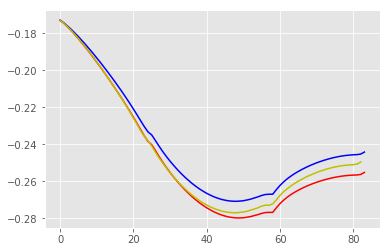

KeyboardInterrupt: 

In [121]:
for i in range(38):
    traj_true = subsample(trajs_true[index],3351/40)
    plt.plot(result['gpr']['trajs'][index][:,i],'r')
    plt.plot(result['gpr_A']['trajs'][index][:,i],'b')
    plt.plot(traj_true[:,i],'y')
    plt.show()
    raw_input()
    plt.clf()
    clear_output()

